## Quantum Graph Recurrent Neural Network

In [71]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
import networkx as nx

In [72]:
qubit_number = 4
qubits = range(qubit_number)

Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]


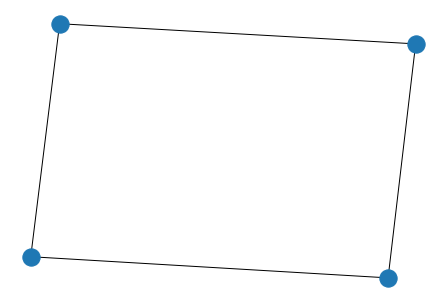

In [73]:
ising_graph = nx.cycle_graph(qubit_number)

nx.draw(ising_graph)
print(f"Edges: {ising_graph.edges}")

In [74]:
matrix_params = [[-0.3, 0.58, -0.77, 0.83], [0.7, 0.82, 0.17, 0.14]]

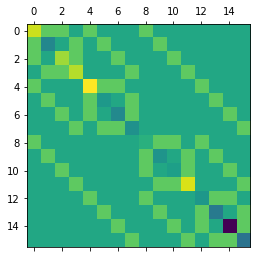

In [75]:
def create_hamiltonian_matrix(n, graph, params):

    matrix = np.zeros((2 ** n, 2 ** n))

    # Creates the interaction component of the Hamiltonian
    for count, i in enumerate(graph.edges):
        m = 1
        for j in range(0, n):
            if i[0] == j or i[1] == j:
                m = np.kron(m, qml.PauliZ.matrix)
            else:
                m = np.kron(m, np.identity(2))
        matrix += params[0][count] * m

    # Creates the bias components of the matrix
    for i in range(0, n):
        m1 = m2 = 1
        for j in range(0, n):
            if j == i:
                m1 = np.kron(m1, qml.PauliZ.matrix)
                m2 = np.kron(m2, qml.PauliX.matrix)
            else:
                m1 = np.kron(m1, np.identity(2))
                m2 = np.kron(m2, np.identity(2))
        matrix += (params[1][i] * m1 + m2)

    return matrix

# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix(qubit_number, ising_graph, matrix_params)
plt.matshow(ham_matrix)
plt.show()

In [86]:
low_energy_state = [
    (-0.013362676811000984+0.01848837201490736j), 
    (0.0055058467277928486-0.00761807203828898j), 
    (0.04222361871767595-0.05842955057002197j), 
    (-0.017397470231715645+0.02407570142636189j), 
    (0.04887593184748504-0.06761882026072961j), 
    (-0.02013843436600874+0.027862109435986607j), 
    (-0.15443902122811004+0.21369849609273753j), 
    (0.06363377561768266-0.08805375262713072j), 
    (0.04097213421613327-0.05668302367058239j), 
    (-0.01688181902472944+0.02335605091822253j), 
    (-0.12946446399364614+0.1791376554418468j), 
    (0.053343465857217845-0.07381307351505137j), 
    (-0.1498615328819493+0.20731079929775745j), 
    (0.06174770560080939-0.08542172374163193j), 
    (0.4735350881198678-0.6551727181751797j), 
    (-0.195111477477142+0.2699617338281479j)
]

In [87]:
energy_exp = np.vdot(low_energy_state, (ham_matrix @ low_energy_state))
print(f"Energy Expectation: {np.real_if_close(energy_exp)}")


ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix)[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: -5.254285309442025
Ground State Energy: -5.317503102305561


In [88]:
def state_evolve(hamiltonian, qubits, time):

    U = scipy.linalg.expm(-1j* hamiltonian * time)
    qml.QubitUnitary(U, wires=qubits)

In [96]:
def qgrnn_layer(param1, param2, qubits, graph, trotter_step):

    # Applies a layer of RZZ gates (based on a graph)
    for count, i in enumerate(graph.edges):
        qml.MultiRZ(2 * param1[count] * trotter_step, wires=[i[0], i[1]])

    # Applies a layer of RZ gates
    for count, i in enumerate(qubits):
        qml.RZ(2 * param2[count] * trotter_step, wires=i)

    # Applies a layer of RX gates
    for i in qubits:
        qml.RX(2 * trotter_step, wires=i)

In [97]:
def swap_test(control, register1, register2):

    qml.Hadamard(wires=control)
    for i in range(0, len(register1)):
        qml.CSWAP(wires=[int(control), register1[i], register2[i]])
    qml.Hadamard(wires=control)

Edges: [(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


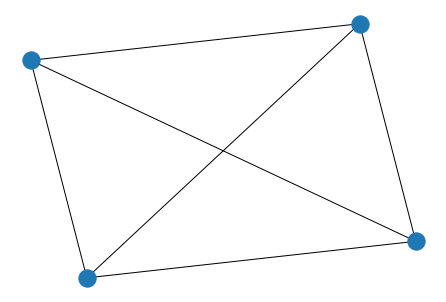

In [98]:
reg1 = list(range(qubit_number))  # First qubit register
reg2 = list(range(qubit_number, 2 * qubit_number))  # Second qubit register

control = 2 * qubit_number  # Index of control qubit
trotter_step = 0.01  # Trotter step size

# Defines the interaction graph for the new qubit system

new_ising_graph = nx.Graph()
new_ising_graph.add_nodes_from(range(qubit_number, 2 * qubit_number))
new_ising_graph.add_edges_from([(4, 5), (5, 6), (6, 7), (4, 6), (7, 4), (5, 7)])

print(f"Edges: {new_ising_graph.edges}")
nx.draw(new_ising_graph)

In [99]:
def qgrnn(params1, params2, time=None):

    # Prepares the low energy state in the two registers
    qml.QubitStateVector(np.kron(low_energy_state, low_energy_state), wires=reg1+reg2)

    # Evolves the first qubit register with the time-evolution circuit to prepare a piece of quantum data
    state_evolve(ham_matrix, reg1, time)

    # Applies the QGRNN layers to the second qubit register
    depth = time / trotter_step  # P = t/Delta
    for i in range(0, int(depth)):
        qgrnn_layer(params1, params2, reg2, new_ising_graph, trotter_step)

    # Applies the SWAP test between the registers
    swap_test(control, reg1, reg2)

    # Returns the results of the SWAP test
    return qml.expval(qml.PauliZ(control))

In [100]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data

In [101]:
def cost_function(params):

    global iterations

    # Separates the parameter list
    weight_params = params[0:6]
    bias_params = params[6:10]

    # Randomly samples times at which the QGRNN runs
    times_sampled = [np.random.uniform() * max_time for i in range(0, N)]

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for i in times_sampled:
        result = qnode(weight_params, bias_params, time=i)
        total_cost += -1 * result

    # Prints the value of the cost function
    if iterations % 1 == 0:
        print("Fidelity at Step " + str(iterations) + ": " + str((-1 * total_cost / N)._value))
        print("Parameters at Step " + str(iterations) + ": " + str(params._value))
        print("---------------------------------------------")

    iterations += 1

    return total_cost / N

In [102]:
qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1)

# Defines the new QNode

qnode = qml.QNode(qgrnn, qgrnn_dev)

iterations = 0
optimizer = qml.AdamOptimizer(stepsize=0.3)
steps = 200
qgrnn_params = list([np.random.randint(-20, 20)/50 for i in range(0, 10)])

# Executes the optimization method

for i in range(0, steps):
    qgrnn_params = optimizer.step(cost_function, qgrnn_params)

print(f"Final Parameters: {qgrnn_params}")

Fidelity at Step 0: 0.9917117903267746
Parameters at Step 0: [0.1, -0.06, -0.32, -0.1, -0.12, 0.3, -0.36, 0.08, 0.0, -0.28]
---------------------------------------------
Fidelity at Step 1: 0.9978193274344885
Parameters at Step 1: [-0.19999942483436658, -0.35999932957954794, -0.020000574944895433, -0.3999992147181055, 0.17999917428337991, 0.5999991717365344, -0.060000819803977756, 0.37999870765626914, 0.2999983982338462, -0.5799986437975151]
---------------------------------------------
Fidelity at Step 2: 0.9984668053059643
Parameters at Step 2: [-0.4150895661758315, -0.570546188333741, 0.18975248818895452, -0.6098277191594572, 0.38231095611109306, 0.8004490859172586, 0.15619179647119733, 0.5938178952216149, 0.5031539439977973, -0.7739155080425429]
---------------------------------------------
Fidelity at Step 3: 0.9958839656108402
Parameters at Step 3: [-0.5828562020495468, -0.7304167482323325, 0.3484099417220862, -0.7685470608269184, 0.5281233652551159, 0.9431797051141009, 0.3258328

In [ ]:
[[-0.3, 0.58, -0.77, 0.83], [0.7, 0.82, 0.17, 0.14]]

new_ham_matrix = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), [qgrnn_params[0:6], qgrnn_params[6:10]]
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

axes[0].matshow(new_ham_matrix)
axes[0].set_title("Learned Hamiltonian", y=1.13)


axes[1].matshow(ham_matrix)
axes[1].set_title("Target Hamiltonian", y=1.13)

fig.tight_layout()

plt.show()

In [ ]:
qgrnn_params = list(qgrnn_params)

zero_weights = [qgrnn_params[1], qgrnn_params[4]]

del qgrnn_params[1]
del qgrnn_params[3]

In [ ]:
target_params = matrix_params[0] + matrix_params[1]

print(f"Target parameters: {target_params}")
print(f"Learned parameters: {qgrnn_params}")
print(f"Non-Existing Edge Parameters: {zero_weights}")